In [1]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import MathsUtilities as MUte
%matplotlib inline

In [2]:
Colors = ['darkblue',           
'darkcyan',           
'darkgoldenrod',      
'darkgray',           
'darkgreen',          
'darkkhaki',          
'darkmagenta',        
'darkolivegreen',     
'darkorange',         
'darkorchid',         
'darkred',            
'darkviolet',
'blue',           
'cyan',           
'goldenrod',      
'gray',           
'green',
'black']
Markers = ['o','s','^']

In [3]:
con = sqlite3.connect(r'C:\Users\cflhxb\Dropbox\APSIMPotato\Potato.db')

In [20]:
HarvestObsPred = pd.read_sql("Select * from FinalYieldData",
                        con)
#HarvestObsPred.set_index('SimulationID',inplace=True)

In [5]:
Factors = pd.read_sql("Select * from _Factors",
                        con)
ValidationIndex = Factors.drop_duplicates(subset=['SimulationName']).loc[:,Factors.columns.isin(['SimulationID','ExperimentName','SimulatinName','FolderName'])]
Experiments = ValidationIndex.ExperimentName.drop_duplicates().tolist()
Folders = ValidationIndex.FolderName.drop_duplicates().tolist()

In [23]:
HarvestObsPred

,CheckpointID,Observed.CheckpointID,Predicted.CheckpointID,SimulationID,Observed.Clock.Today,Predicted.Clock.Today,Predicted.Potato.Stem.Live.N,Predicted.Potato.Stem.Live.NConc,Predicted.Potato.Stem.Live.Wt,Predicted.Potato.Total.N,...,PlantandHarvest.Script.FinalTag,Observed.Potato.TotalLive.N,Observed.Potato.TotalLive.Wt,Observed.Potato.Tuber.LiveFWt.DryMatterContent.Value(),Observed.Potato.Tuber.Live.N,Observed.Potato.Tuber.Live.NConc,Observed.Potato.Stem.Live.Wt,Observed.Potato.Stem.Live.N,Observed.Potato.Total.N,Observed.Potato.Stem.Live.NConc
0,1,1,1,266,1985-05-02 12:00:00,1985-07-23 12:00:00,0.356341,0.006222,57.271724,5.825761,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,270,1985-10-18 12:00:00,1985-10-13 12:00:00,0.158596,0.006797,23.333260,3.982583,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,267,1985-05-10 12:00:00,1985-07-23 12:00:00,0.356341,0.006222,57.271724,5.825761,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,268,1985-05-20 12:00:00,1985-07-23 12:00:00,0.356341,0.006222,57.271724,5.825761,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,1,269,1985-10-12 12:00:00,1985-10-13 12:00:00,0.158596,0.006797,23.333260,3.982583,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1,1,272,1993-10-28 12:00:00,1993-11-15 12:00:00,2.281922,0.019292,118.284404,23.746855,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,1,1,271,1985-10-01 12:00:00,1985-10-13 12:00:00,0.158596,0.006797,23.333260,3.982583,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,1,1,273,1993-10-28 12:00:00,1993-11-15 12:00:00,2.281922,0.019292,118.284404,23.746855,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,1,1,274,1993-10-28 12:00:00,1993-11-15 12:00:00,2.281922,0.019292,118.284404,23.746855,...,yield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,1,1,4,2004-06-01 12:00:00,2004-06-02 12:00:00,4.279892,0.028907,148.058336,27.471964,...,yield,18.68,1180.700000,0.203000,18.680000,0.015900,NaN,NaN,NaN,NaN


In [14]:
list(HarvestObsPred.columns)

['CheckpointID',
 'Observed.CheckpointID',
 'Predicted.CheckpointID',
 'Observed.Clock.Today',
 'Predicted.Clock.Today',
 'Predicted.Potato.Stem.Live.N',
 'Predicted.Potato.Stem.Live.NConc',
 'Predicted.Potato.Stem.Live.Wt',
 'Predicted.Potato.Total.N',
 'Predicted.Potato.TotalLive.N',
 'Predicted.Potato.TotalLive.Wt',
 'Predicted.Potato.Tuber.LiveFWt.DryMatterContent.Value()',
 'Predicted.Potato.Tuber.Live.N',
 'Predicted.Potato.Tuber.Live.NConc',
 'Observed.Potato.Tuber.Live.Wt',
 'Predicted.Potato.Tuber.Live.Wt',
 'Observed.Potato.Tuber.LiveFWt',
 'Predicted.Potato.Tuber.LiveFWt',
 'PlantandHarvest.Script.FinalTag',
 'Observed.Potato.TotalLive.N',
 'Observed.Potato.TotalLive.Wt',
 'Observed.Potato.Tuber.LiveFWt.DryMatterContent.Value()',
 'Observed.Potato.Tuber.Live.N',
 'Observed.Potato.Tuber.Live.NConc',
 'Observed.Potato.Stem.Live.Wt',
 'Observed.Potato.Stem.Live.N',
 'Observed.Potato.Total.N',
 'Observed.Potato.Stem.Live.NConc']

In [7]:
pd.options.display.max_rows = 999

In [10]:
Factors.sort_values(by='SimulationID')

,CheckpointID,SimulationID,ExperimentName,SimulationName,FolderName,FactorName,FactorValue
13,1,1,ABlock,ABlockCultivarBurbank,New Zealand,Cultivar,Burbank
14,1,2,ABlock,ABlockCultivarHorizon,New Zealand,Cultivar,Horizon
15,1,3,ABlock,ABlockCultivarIlamHardy,New Zealand,Cultivar,IlamHardy
16,1,4,ABlock,ABlockCultivarJerseyBenny,New Zealand,Cultivar,JerseyBenny
17,1,5,ABlock,ABlockCultivarKaraka,New Zealand,Cultivar,Karaka
18,1,6,ABlock,ABlockCultivarNooksac,New Zealand,Cultivar,Nooksac
19,1,7,ABlock,ABlockCultivarRedRascal,New Zealand,Cultivar,RedRascal
20,1,8,ABlock,ABlockCultivarRua,New Zealand,Cultivar,Rua
22,1,9,Baxters,BaxtersPlantingDate14OctPlantDensity4,New Zealand,PlantDensity,4
21,1,9,Baxters,BaxtersPlantingDate14OctPlantDensity4,New Zealand,PlantingDate,14Oct


In [16]:
Experiments

['ABlock',
 'Baxters',
 'FUE',
 'FSP',
 'FUE_NI',
 'Parilla',
 'Penola_0607',
 'Glenroy_0607',
 'AUCB7001',
 'CHBE9801',
 'CHBE9901',
 'CHFI9801',
 'CHFI9901',
 'CHGR98',
 'CHGR980',
 'CHIE98',
 'CHIE980',
 'CHIT98',
 'CHIT980',
 'CHSE98',
 'CHUK98',
 'CPLI9201',
 'DIJY8401Tylva_84',
 'DIJY8401Tylva_85',
 'DIJY8401Tylva_86',
 'DIJY9001Kap_90',
 'DIJY9001Kap_91',
 'DIJY9001Kap_92',
 'DIJY9001Kap_93',
 'DITY8101_81',
 'DITY8101_82',
 'DITY8101_83',
 'IAHM9801',
 'IAWM9901',
 'INBA9101',
 'IPSG8501',
 'OSBO8801NASA_PIX',
 'PRBE9701',
 'PRKO9701',
 'PRPA9701',
 'PRPT9801',
 'PRPT9802',
 'PRTO9301',
 'PULU0801_2008',
 'PULU0801_2010',
 'SCDU8401_1984',
 'SCDU8401_1985',
 'SFUF1001_2011',
 'SFUF1001_2012',
 'UFHA1001_F1',
 'UFHA1001_F2',
 'UFHA1001_F3',
 'UFSF01',
 'UFSF010',
 'CPLM8501VERANO',
 'CPLM8501INVIERNO',
 'CPSR9302',
 'CHUK980']

In [11]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text += '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\nn = ' + str(RegStats.n)
    return text

In [20]:
HarvestObsPred

,CheckpointID,Observed.CheckpointID,Predicted.CheckpointID,Observed.Clock.Today,Predicted.Clock.Today,Predicted.Potato.Leaf.AppearedCohortNo,Predicted.Potato.Leaf.CoverGreen,Predicted.Potato.Leaf.LAI,Predicted.Potato.Leaf.Live.N,Predicted.Potato.Leaf.Live.Wt,...,Predicted.Potato.Tuber.Live.N,Observed.Potato.Tuber.Live.NConc,Predicted.Potato.Tuber.Live.NConc,Observed.Potato.Tuber.Live.Wt,Predicted.Potato.Tuber.Live.Wt,Observed.Potato.Tuber.LiveFWt,Predicted.Potato.Tuber.LiveFWt,PlantandHarvest.Script.FinalTag,Observed.Potato.Stem.Live.Wt,Observed.Potato.Phenology.CurrentPhaseName
SimulationID,,,,,,,,,,,,,,,,,,,,,


In [14]:
Graph = plt.figure(figsize=(15,15))
Variables = ['AboveGround.Wt','Grain.Number','Grain.Wt',
             'AboveGround.N','Grain.N','Grain.Protein',
             'Phenology.FlagLeafDAS.Value()','Phenology.FloweringDAS.Value()']
Units = ['$g/m^3$','$/m^3$','$g/m^3$',
        '$g/m^3$','$g/m^3$','$g/m^3$',
        'days','days']
Names = ['Biomass','Grain Number', 'Yield', 'Biomass N', 'Grain N',
         'Grain Protein', 'Flag Leaf','Anthesis']
Pos = 1
for Var in Variables:
    NaNFilter = np.isnan(HarvestObsPred.loc[:,'Predicted.Potato.'+Var]) | np.isnan(HarvestObsPred.loc[:,'Observed.Potato.'+Var])
    IaNFilter = ~NaNFilter
    Obs = HarvestObsPred.loc[:,'Observed.Potato.'+Var].loc[IaNFilter].values
    Pred = HarvestObsPred.loc[:,'Predicted.Potato.'+Var].loc[IaNFilter].values
    Graph.add_subplot(3,3,Pos)
    ColPos = 0
    MarPos = 0
    for Fol in Folders:
        SimIDs = Factors.loc[Factors.FolderName == Fol].SimulationID.values
        ExpObs = HarvestObsPred.loc[SimIDs,'Observed.Potato.'+Var]
        ExpPred = HarvestObsPred.loc[SimIDs,'Predicted.Potato.'+Var]
        plt.plot(ExpObs,ExpPred,Markers[MarPos],color = Colors[ColPos],label=Fol)
        ColPos +=1
        if ColPos > 16:
            ColPos = 1
            MarPos +=1
    uplim = max(Obs.max(),Pred.max())*1.1
    lowlim = min(Obs.min(),Pred.min())*0.95
    plt.title(Names[Pos-1] + ' (' + Units[Pos-1] + ')')
    plt.ylim(0,uplim)
    plt.xlim(0,uplim)
    plt.plot([lowlim,uplim*.95],[lowlim,uplim*.95],'-')
    RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
    LabelText = MakeLabel(RegStats)
    plt.text(uplim*0.05,uplim*.78,LabelText)
    #Fit linear regression to current series and store slope and intercept in dataframe
    ModFit = sm.regression.linear_model.OLS(Pred,  # Y variable
                                        sm.add_constant(Obs), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
    RegFit = ModFit.fit();  # fit models parameters
    Slope = RegFit.params[1] 
    Intercept = RegFit.params[0]
    Xs = [lowlim,uplim*.95]
    Ys = [Intercept + Xs[0]*Slope,Intercept + Xs[1]*Slope]
    plt.plot(Xs,Ys,'--')
    Pos +=1
plt.text(70,-50,'Observed',fontsize=20)
plt.text(-420,580,'Predicted',fontsize=20,rotation=90)
plt.legend(loc = (1.2,0),ncol=1,numpoints=1,markerscale=2)

KeyError: 'the label [Predicted.Potato.AboveGround.Wt] is not in the [columns]'

<Figure size 1080x1080 with 0 Axes>

In [10]:
DailyObsPred = pd.read_sql("Select * from DailyObsPred",
                        con)

In [11]:
RegStats = MUte.MathUtilities.CalcRegressionStats('Test',Obs,Pred)

In [12]:
def add_subplot_axes(ax,rect,uplim,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3] 
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg,alpha=0.0)
#     x_labelsize = subax.get_xticklabels()[0].get_size()
#     y_labelsize = subax.get_yticklabels()[0].get_size()
#     x_labelsize *= rect[2]**0.5
#     y_labelsize *= rect[3]**0.5
#     subax.xaxis.set_tick_params(labelsize=x_labelsize)
#     subax.yaxis.set_tick_params(labelsize=y_labelsize)
#     #subax.ylim(0,uplim)
    #subax.xlim(0,uplim)
    subax.spines['left'].set_visible(False)
    subax.spines['top'].set_visible(False)
    subax.yaxis.set_ticks_position('left')
    subax.xaxis.set_ticks_position('bottom')
    subax.patch.set_alpha(0)
    subax.xaxis.major.locator.set_params(nbins=2) 
    subax.yaxis.major.locator.set_params(nbins=2)
    return subax

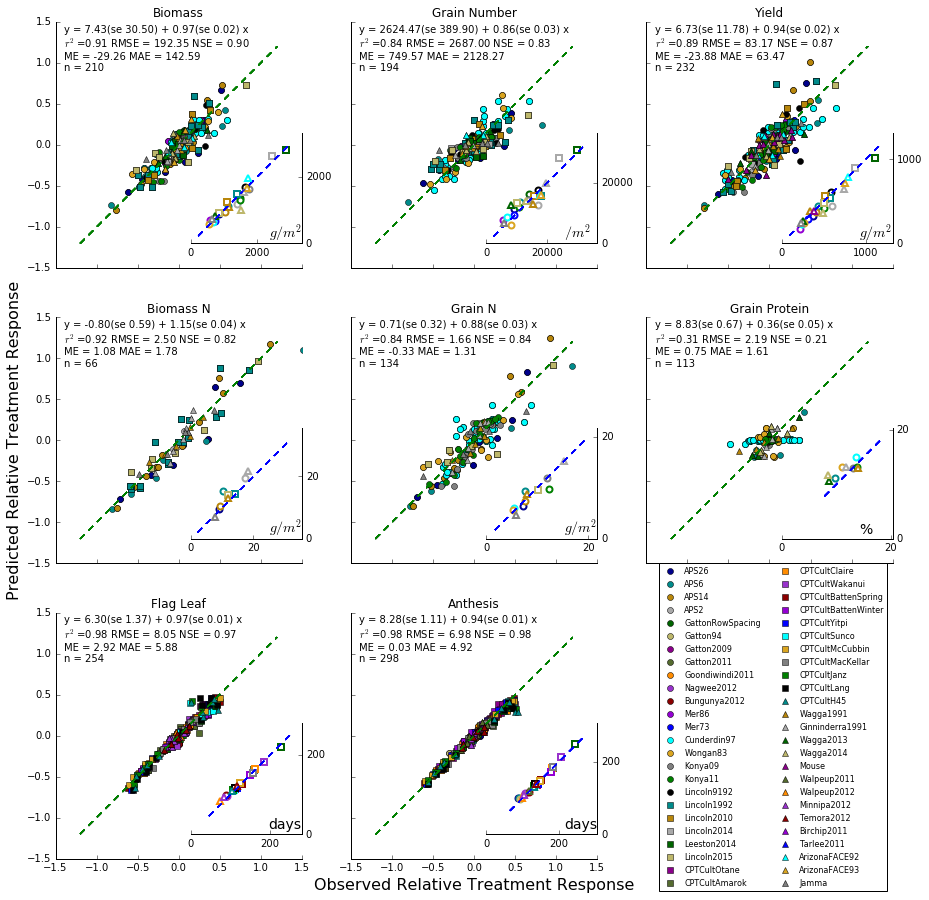

In [13]:
#initialise graph bits
Graph = plt.figure(figsize=(15,15))
axes = []
insets = []
rect = [0.55, 0.1, .45, .45]
Variables = ['AboveGround.Wt','Grain.Number','Grain.Wt',
             'AboveGround.N','Grain.N','Grain.Protein',
            'Phenology.FlagLeafDAS.Value()','Phenology.FloweringDAS.Value()']
Units = ['$g/m^2$','$/m^2$','$g/m^2$',
        '$g/m^2$','$g/m^2$','%',
        'days','days']
Names = ['Biomass','Grain Number', 'Yield', 'Biomass N', 'Grain N',
         'Grain Protein', 'Flag Leaf','Anthesis']
Pos = 1
#Step through each variable to be graphed
for Var in Variables:
    #Add a subplot
    axes.append(Graph.add_subplot(3,3,Pos))
    #Set up the Data to be graphed
    NaNFilter = np.isnan(HarvestObsPred.ix[:,'Predicted.Wheat.'+Var]) | np.isnan(HarvestObsPred.ix[:,'Observed.Wheat.'+Var])
    IaNFilter = ~NaNFilter
    Obs = HarvestObsPred.ix[:,'Observed.Wheat.'+Var].ix[IaNFilter].values
    Pred = HarvestObsPred.ix[:,'Predicted.Wheat.'+Var].ix[IaNFilter].values
    #Derive some things from the data
    uplim = max(Obs.max(),Pred.max())*1.1
    lowlim = min(Obs.min(),Pred.min())*0.95
    RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
    LabelText = MakeLabel(RegStats)
    plt.text(-1.4,0.9,LabelText)
    #Step through each experiment in the data set
    ColPos = 0
    ColPos2 = 0
    MarPos = 0
    MarPos2 = 0
    for Exp in Experiments:
        #Select data for the experiment and calculate means
        RelObs = []
        RelPred = []
        ObsResp = []
        PredResp = []
        SimIDs = Factors.ix[Factors.ExperimentName == Exp].SimulationID.values
        ExpObs = HarvestObsPred.ix[SimIDs,'Observed.Wheat.'+Var].values
        ObsMean = HarvestObsPred.ix[SimIDs,'Observed.Wheat.'+Var].mean()
        ExpPred = HarvestObsPred.ix[SimIDs,'Predicted.Wheat.'+Var].values
        PredMean = HarvestObsPred.ix[SimIDs,'Predicted.Wheat.'+Var].mean()
        #Calculate relative treatment responses
        for x in range(len(ExpObs)):
            ObsResp.append((ExpObs[x]-ObsMean)/ObsMean)
            PredResp.append((ExpPred[x]-PredMean)/PredMean)
        #Plot relative responses
        plt.plot([-1.2,1.2],[-1.2,1.2],'--',color='g')
        plt.plot(ObsResp,PredResp,Markers[MarPos2],color = Colors[ColPos2],label=Exp)
        axes[Pos-1].spines['right'].set_visible(False)
        axes[Pos-1].spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
        plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
        plt.title(Names[Pos-1])
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        ColPos2 +=1
        if ColPos2 > 17:
            ColPos2 = 1
            MarPos2 +=1
        if Pos in [1,2,3,4,5,6]:
            axes[Pos-1].tick_params(labelbottom='off') 
        if Pos in [2,3,5,6,8,9]:
            axes[Pos-1].tick_params(labelleft='off') 
        if Pos == 4:
            plt.ylabel('Predicted Relative Treatment Response', fontsize =16)
        if Pos == 8: 
            plt.xlabel('Observed Relative Treatment Response', fontsize =16)
            plt.legend(loc = (1.25,-.13),numpoints=1,fontsize=8,ncol=2)
    #Add insert into pannel to graph experimental means
    insets.append(add_subplot_axes(axes[Pos-1],rect,uplim))
    #Step through experiments and add means to inset
    for Exp in Experiments:
        SimIDs = Factors.ix[Factors.ExperimentName == Exp].SimulationID.values
        ExpObs = HarvestObsPred.ix[SimIDs,'Observed.Wheat.'+Var].mean()
        ExpPred = HarvestObsPred.ix[SimIDs,'Predicted.Wheat.'+Var].mean()
        plt.plot([lowlim*1.2,uplim*.9],[lowlim*1.2,uplim*.9],'--',color='b')
        plt.plot(ExpObs,ExpPred,Markers[MarPos],mec = Colors[ColPos],mfc='white',label=Exp,mew=2)
        ColPos +=1
        if ColPos > 17:
            ColPos = 1
            MarPos +=1
    plt.ylim(0,uplim)
    plt.xlim(0,uplim)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='off',right='on', labelright='on', labelleft='off')
    plt.text(uplim*0.7,uplim*.05,Units[Pos-1],fontsize = 14)
    Pos +=1
plt.tight_layout 
Graph.savefig('ModelAssessment.jpg',dpi=200,pad_inches=1)

In [15]:
Experiments

[u'APS6',
 u'APS26',
 u'APS14',
 u'APS2',
 u'GattonRowSpacing',
 u'Gatton94',
 u'Gatton2009',
 u'Gatton2011',
 u'Goondiwindi2011',
 u'Nagwee2012',
 u'Bungunya2012',
 u'Mer86',
 u'Mer73',
 u'Cunderdin97',
 u'Wongan83',
 u'Konya09',
 u'Lincoln9192',
 u'Konya11',
 u'Lincoln1992',
 u'Lincoln2010',
 u'Lincoln2014',
 u'Leeston2014',
 u'Lincoln2015',
 u'CPTCultOtane',
 u'CPTCultAmarok',
 u'CPTCultClaire',
 u'CPTCultWakanui',
 u'CPTCultBattenSpring',
 u'CPTCultBattenWinter',
 u'CPTCultYitpi',
 u'CPTCultSunco',
 u'CPTCultMcCubbin',
 u'CPTCultMacKellar',
 u'CPTCultJanz',
 u'CPTCultLang',
 u'CPTCultH45',
 u'Wagga1991',
 u'Ginninderra1991',
 u'Wagga2013',
 u'Wagga2014',
 u'Mouse',
 u'Walpeup2011',
 u'Walpeup2012',
 u'Minnipa2012',
 u'Temora2012',
 u'Birchip2011',
 u'Tarlee2011',
 u'ArizonaFACE92',
 u'ArizonaFACE93',
 u'Jamma']

In [16]:
YieldProfitValidation = pd.read_excel('WheatValidation.xlsx',sheetname='Sheet1')

In [17]:
YieldProfitValidation.ix[:,'Year'] = YieldProfitValidation.ix[:,'Clock.Today'].dt.year

In [18]:
YearList = YieldProfitValidation.ix[:,'Year'].dropna().drop_duplicates()

In [19]:
(YieldProfitValidation.ix[:,'Comments' ])==0

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1521    False
1522    False
1523    False
1524    False
1525    False
1526    False
1527    False
1528    False
1529    False
1530    False
1531    False
1532    False
1533    False
1534    False
1535    False
1536    False
1537    False
1538    False
1539    False
1540    False
1541    False
1542    False
1543    False
1544    False
1545    False
1546    False
1547    False
1548    False
1549    False
1550    False
Name: Comments, dtype: bool

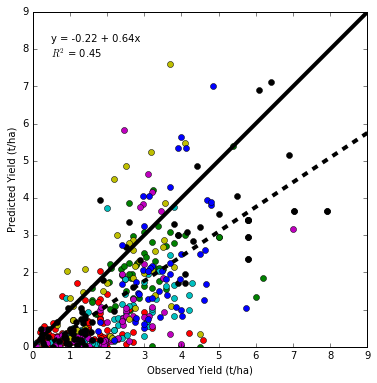

In [20]:
Graph = plt.figure(figsize=(6,6))
for Year in YearList:
    filter = (YieldProfitValidation.ix[:,'Year'] == Year) & (YieldProfitValidation.ix[:,'Observed Yield']>0) & (YieldProfitValidation.ix[:,'WetYield']>0) &(YieldProfitValidation.ix[:,'Comments' ]==0)
    plt.plot(YieldProfitValidation.ix[filter,'Observed Yield']/100,
            YieldProfitValidation.ix[filter, 'WetYield']/100,
            'o')

filter = (YieldProfitValidation.ix[:,'Observed Yield']>0) & (YieldProfitValidation.ix[:,'WetYield']>0) &(YieldProfitValidation.ix[:,'Comments' ]==0)
Pred = YieldProfitValidation.ix[filter, 'WetYield']/100
Obs = YieldProfitValidation.ix[filter,'Observed Yield']/100
RegStats = MUte.MathUtilities.CalcRegressionStats('Grain.Wt',Pred.values,Obs.values)
plt.ylim(0,9)
plt.xlim(0,9)
plt.plot([0,9],[0,9],'-',color='k',linewidth=4)
stats = 'y = ' +'%.2f'%RegStats.Intercept + ' + ' + '%.2f'%RegStats.Slope + 'x \n$R^2$ = ' + '%.2f'%RegStats.R2
plt.text(0.5,7.8,stats)
plt.plot([0,9],[RegStats.Intercept,RegStats.Intercept/100+900*RegStats.Slope/100],
        '--',color='k',linewidth = 4)
plt.xlabel('Observed Yield (t/ha)')
plt.ylabel('Predicted Yield (t/ha)')

In [ ]:
Pred = YieldProfitValidation.ix[filter, 'WetYield']
Obs = YieldProfitValidation.ix[filter,'Observed Yield']
test = MUte.MathUtilities.CalcRegressionStats('Grain.Wt',Pred.values,Obs.values)

In [ ]:
'%.2f'%test.Intercept

In [ ]:
test.Slope

In [ ]:
test.R2

In [ ]:
Obs.size